# 목차
 * 프로젝트 준비단계
 * 프로젝트: 멋진 작사가 만들기
 
 
# 루브릭 평가 기준
 1. 가사 텍스트 생성 모델이 정상적으로 동작하는가?
 2. 데이터의 전처리와 데이터셋 구성 과정이 체계적으로 진행되었는가?
 3. 텍스트 생성모델이 안정적으로 학습되었는가?

 
# 소감
 자연어처리라는 것을 처음 접해본다. 
 분명 어려울것이고 여전히 나의 목표인 하나하나 뜯어보기는 오늘도 실패이다. 
 과제에서 본 데이터양을 딱 맞추지 못했고 "와 신기하다 라는 생각까지는 안든다...." 
 점점 해야하는 공부량은 늘어나고 있는데 아직 기초단계에서 헤엄치고 있고 자꾸 접하다 보면 하나하나 이해할 날이 올거라고 믿는다
 자연어 처리쪽으로 진로를 선택하면 어떨까 고민을 하게 하는 프로젝트 였다. 
 

# 프로젝트 준비단계 

앞에서 먹었다 를 만드는 법은 배웠지만, 가장 첫 시작인 나는 은 어떻게 만들어야 할까요?

이는 <start> 라는 특수한 토큰을 맨 앞에 추가해 줌으로써 해결할 수 있습니다. 인공지능에게 "자, 이제 어떤 문장이든 생성해봐!" 라는 사인을 주는 셈인 거죠. <start> 를 입력으로 받은 순환신경망은 다음 단어로 나는 을 생성하고, 생성한 단어를 다시 입력으로 사용합니다. 이 순환적인 특성을 살려 순환신경망이라고 이름을 붙인 것이죠!

그렇게 순차적으로 밥을 먹었다 까지 생성하고 나면, 인공지능은 "다 만들었어!" 라는 사인으로 <end> 라는 특수한 토큰을 생성합니다. 즉, 우리는 <start> 가 문장의 시작에 더해진 입력 데이터(문제지)와, <end> 가 문장의 끝에 더해진 출력 데이터(답안지)가 필요하며, 이는 문장 데이터만 있으면 만들어낼 수 있다는 것 또한 알 수 있습니다.

In [1]:
sentence = " 나는 밥을 먹었다 "

source_sentence = "<start>" + sentence
target_sentence = sentence + "<end>"

print("Source 문장:", source_sentence)
print("Target 문장:", target_sentence)

Source 문장: <start> 나는 밥을 먹었다 
Target 문장:  나는 밥을 먹었다 <end>


## 실습(1) 데이터 다듬기 - 데이터 전처리

이번 실습에서는 연극의 대사를 학습해서 스스로 연극 대사 문장을 생성해내는 언어 모델 인공지능을 만들 겁니다

### 데이터 다운로드
$ mkdir -p ~/aiffel/lyricist/models 
$ ln -s ~/data ~/aiffel/lyricist/data


In [26]:
import os, re 
import numpy as np
import tensorflow as tf

# 파일을 읽기모드로 열고
# 라인 단위로 끊어서 list 형태로 읽어옵니다.
file_path = os.getenv('HOME') + '/aiffel/lyricist/data/shakespeare.txt'
with open(file_path, "r") as f:
    raw_corpus = f.read().splitlines()

# 앞에서부터 10라인만 화면에 출력해 볼까요?
print(raw_corpus[:9])
print("데이터 크기:", len(raw_corpus))


['First Citizen:', 'Before we proceed any further, hear me speak.', '', 'All:', 'Speak, speak.', '', 'First Citizen:', 'You are all resolved rather to die than to famish?', '']
데이터 크기: 40000


==> 1차 필터링하기
완벽한 연극 대본이군요! 하지만 우린 문장(대사) 만을 원하므로 화자 이름이나 공백뿐인 정보는 필요가 없습니다.
화자가 표기된 문장은 문장의 끝이 :로 끝나게 되어 있죠. 
일반적으로 대사가 : 로 끝나는 일은 없을테니, : 를 기준으로 문장을 제외해도 괜찮을 것 같습니다. 
그리고 공백인 문장은 길이를 검사하여 길이가 0이라면 제외를 시키죠!

In [6]:
for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue   # 길이가 0인 문장은 건너뜁니다.
    if sentence[-1] == ":": continue  # 문장의 끝이 : 인 문장은 건너뜁니다.

    if idx > 9: break   # 일단 문장 10개만 확인해 볼 겁니다.
        
    print(sentence)

Before we proceed any further, hear me speak.
Speak, speak.
You are all resolved rather to die than to famish?


### 토큰화

텍스트 분류 모델에서 많이 보신 것처럼 텍스트 생성 모델에도 단어 사전을 만들게 됩니다. 
그렇다면 문장을 일정한 기준으로 쪼개야겠죠? 그 과정을 토큰화(Tokenize) 라고 합니다.

가장 심플한 방법은 띄어쓰기를 기준으로 나누는 방법이고, 우리도 그 방법을 사용할 겁니다. 
하지만 약간의 문제가 있을 수 있죠. 
몇 가지 문제 케이스를 살펴보죠.

1. Hi, my name is John. *("Hi," "my", ..., "john." 으로 분리됨) - 문장부호  ==>  문장 부호 양쪽에 공백을 추가 

2. First, open the first chapter. *(First와 first를 다른 단어로 인식) - 대소문자 ==> 모든 문자들을 소문자로 변환

3. He is a ten-year-old boy. *(ten-year-old를 한 단어로 인식) - 특수문자 ==> 특수문자들은 모두 제거


이런 전처리를 위해 정규표현식(Regex)을 이용한 필터링이 유용하게 사용된다

In [8]:
# 입력된 문장을
#     1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
#     2. 특수문자 양쪽에 공백을 넣고
#     3. 여러개의 공백은 하나의 공백으로 바꿉니다
#     4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
#     5. 다시 양쪽 공백을 지웁니다
#     6. 문장 시작에는 <start>, 끝에는 <end>를 추가합니다
# 이 순서로 처리해주면 문제가 되는 상황을 방지할 수 있겠네요!
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

# 이 문장이 어떻게 필터링되는지 확인해 보세요.
print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>


### 정제 데이터 구축
자연어처리 분야에서 모델의 입력이 되는 문장을 소스 문장(Source Sentence) , 
정답 역할을 하게 될 모델의 출력 문장을 타겟 문장(Target Sentence) 라고 관례적으로 부릅니다. 
각각 X_train, y_train 에 해당한다고 할 수 있겠죠?

그렇다면 우리는 위에서 만든 정제 함수를 통해 만든 데이터셋에서 토큰화를 진행한 후 끝 단어 <end>를 없애면 소스 문장, 
첫 단어 <start>를 없애면 타겟 문장이 되겠죠? 
이 정제 함수를 활용해서 아래와 같이 정제 데이터를 구축합니다!

In [9]:
# 여기에 정제된 문장을 모을겁니다
corpus = []

for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
    
    # 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
        
# 정제된 결과를 10개만 확인해보죠
corpus[:10]

['<start> before we proceed any further , hear me speak . <end>',
 '<start> speak , speak . <end>',
 '<start> you are all resolved rather to die than to famish ? <end>',
 '<start> resolved . resolved . <end>',
 '<start> first , you know caius marcius is chief enemy to the people . <end>',
 '<start> we know t , we know t . <end>',
 '<start> let us kill him , and we ll have corn at our own price . <end>',
 '<start> is t a verdict ? <end>',
 '<start> no more talking on t let it be done away , away ! <end>',
 '<start> one word , good citizens . <end>']

## 벡터화 
인공지능의 모국어라면 단연 숫자 겠죠. 우리는 가르칠 언어(데이터)를 숫자로 변환해서 인공지능에게 줄 겁니다. 
이에 필요한 것은 사전 텐서플로우는 자연어 처리를 위한 여러 가지 모듈을 제공하는데, 우리도 그 모듈을 십분 활용할 겁니다! 
아래에서 활용하게 될 tf.keras.preprocessing.text.Tokenizer 패키지는 정제된 데이터를 토큰화하고, 
단어 사전(vocabulary 또는 dictionary라고 칭함)을 만들어주며, 
데이터를 숫자로 변환까지 한 방에 해줍니다. 

이 과정을 벡터화(vectorize) 라 하며, 숫자로 변환된 데이터를 텐서(tensor) 라고 칭합니다. 
우리가 사용하는 텐서플로우로 만든 모델의 입출력 데이터는 실제로는 모두 이런 텐서로 변환되어 처리되는 것입니다.

In [10]:
# 토큰화 할 때 텐서플로우의 Tokenizer와 pad_sequences를 사용합니다
# 더 잘 알기 위해 아래 문서들을 참고하면 좋습니다
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
def tokenize(corpus):
    # 7000단어를 기억할 수 있는 tokenizer를 만들겁니다
    # 우리는 이미 문장을 정제했으니 filters가 필요없어요
    # 7000단어에 포함되지 못한 단어는 '<unk>'로 바꿀거에요
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=7000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2  143   40 ...    0    0    0]
 [   2  110    4 ...    0    0    0]
 [   2   11   50 ...    0    0    0]
 ...
 [   2  149 4553 ...    0    0    0]
 [   2   34   71 ...    0    0    0]
 [   2  945   34 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f8f2e3082b0>


In [79]:
# 생성된 텐서 데이터를 3번째 행, 10번째 열까지만 출력
print(tensor[:10, :])

[[   2   50    5   91  304   62   57    9  952 6081    3    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0]
 [   2   17 2979  888    4    8   11 6082    6  354    3    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0]
 [   2   32    7   35   15  162  285   28  335    4   48    7   44    3
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0]
 [   2   11  347   24   42    3    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0]
 [   2    6 4735    4    6 2182    3    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0]
 [   2    6 5650  297    4    6 1210  780    3    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0  

===>텐서 데이터는 모두 정수로 이루어져 있습니다. 이 숫자는 다름 아니라, tokenizer에 구축된 단어 사전의 인덱스

단어 사전이 어떻게 구축되었는지 아래와 같이 확인

In [12]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : .
6 : the
7 : and
8 : i
9 : to
10 : of


===> 어떻습니까? 2번 인덱스가 바로 <start>였습니다. 왜 모든 행이 2로 시작하는지 이해할 수 있겠습니다.

### 생성된 텐서를 소스와 타겟으로 분리

이제 생성된 텐서를 소스와 타겟으로 분리하여 모델이 학습할 수 있게 하겠습니다. 
이 과정도 텐서플로우 가 제공하는 모듈을 사용할 것이니, 어떻게 사용하는지만 눈여겨 봐둡시다.

텐서 출력부에서 행 뒤쪽에 0이 많이 나온 부분은 정해진 입력 시퀀스 길이보다 문장이 짧을 경우 0으로 패딩(padding)을 채워 넣은 것입니다. 
사전에는 없지만 0은 바로 패딩 문자 <pad>가 될 것입니다.

In [13]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[  2 143  40 933 140 591   4 124  24 110   5   3   0   0   0   0   0   0
   0   0]
[143  40 933 140 591   4 124  24 110   5   3   0   0   0   0   0   0   0
   0   0]


### 데이터셋 객체 생성
tf.data.Dataset.from_tensor_slices() 메소드를 이용해 tf.data.Dataset객체를 생성할 것입니다.

In [15]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

 # tokenizer가 구축한 단어사전 내 7000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듭니다
# 데이터셋에 대해서는 아래 문서를 참고하세요
# 자세히 알아둘수록 도움이 많이 되는 중요한 문서입니다
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 20), (256, 20)), types: (tf.int32, tf.int32)>

## 실습(2) 인공지능 학습시키기

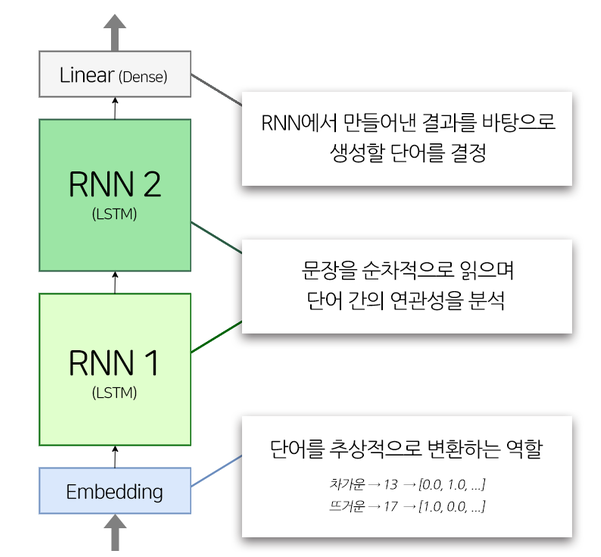

In [16]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256
hidden_size = 1024
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

===> embedding_size 는 워드 벡터의 차원수, 즉 단어가 추상적으로 표현되는 크기, 이번 실습에서는 256이 적당해 보이네요.       

===> LSTM 레이어의 hidden state 의 차원수인 hidden_size 도 같은 맥락입니다. hidden_size 는 모델에 얼마나 많은 일꾼을 둘 것인가? 로 이해해도 크게 엇나가지 않습니다. 그 일꾼들은 모두 같은 데이터를 보고 각자의 생각을 가지는데, 역시 충분한 데이터가 주어지면 올바른 결정을 내리겠지만 그렇지 않으면 배가 산으로 갈 뿐 입니다. 이번 실습에는 1024가 적당해보이는군요.

In [17]:
# 데이터셋에서 데이터 한 배치만 불러오는 방법입니다.
# 지금은 동작 원리에 너무 빠져들지 마세요~
for src_sample, tgt_sample in dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(src_sample)

<tf.Tensor: shape=(256, 20, 7001), dtype=float32, numpy=
array([[[-1.22744063e-06, -3.30609444e-04, -5.91426870e-05, ...,
         -4.20275843e-04, -2.05237855e-04,  5.36298357e-05],
        [ 1.13219910e-04, -6.76916796e-04,  4.56034795e-05, ...,
         -4.53607587e-04, -4.09457280e-04,  1.61670527e-04],
        [ 1.11592155e-04, -8.51868244e-04, -1.68832790e-04, ...,
         -1.68974366e-04, -5.54485479e-04,  2.98661849e-04],
        ...,
        [ 1.20026304e-03, -5.88439812e-04,  9.20215622e-04, ...,
          3.51817277e-03,  1.14534248e-03, -3.02747847e-03],
        [ 1.37954275e-03, -8.90831754e-04,  9.57276032e-04, ...,
          3.91757721e-03,  1.06083823e-03, -3.34095745e-03],
        [ 1.52265327e-03, -1.17925997e-03,  1.00422709e-03, ...,
          4.23588883e-03,  9.83174308e-04, -3.59016308e-03]],

       [[-1.22744063e-06, -3.30609444e-04, -5.91426870e-05, ...,
         -4.20275843e-04, -2.05237855e-04,  5.36298357e-05],
        [-9.20200109e-05, -3.84880754e-04,  4.

모델의 최종 출력 텐서 shape를 유심히 보면 shape=(256, 20, 7001)임을 알 수 있습니다. 
7001은 Dense 레이어의 출력 차원수입니다. 
7001개의 단어 중 어느 단어의 확률이 가장 높을지를 모델링해야 하기 때문입니다.
256은 이전 스텝에서 지정한 배치 사이즈입니다. 
dataset.take(1)를 통해서 1개의 배치, 즉 256개의 문장 데이터를 가져온 것입니다.

그렇다면 20은 무엇을 의미할까요? 
비밀은 바로 tf.keras.layers.LSTM(hidden_size, return_sequences=True)로 호출한 LSTM 레이어에서 return_sequences=True이라고 지정한 부분에 있습니다. 
즉, LSTM은 자신에게 입력된 시퀀스의 길이만큼 동일한 길이의 시퀀스를 출력한다는 의미입니다. 
만약 return_sequences=False였다면 LSTM 레이어는 1개의 벡터만 출력했을 것입니다.

그런데 문제는, 우리의 모델은 입력 데이터의 시퀀스 길이가 얼마인지 모른다는 점입니다. 
모델을 만들면서 알려준 적도 없습니다. 
그럼 20은 언제 알게된 것일까요? 
네, 그렇습니다. 데이터를 입력받으면서 비로소 알게 된 것입니다. 
우리 데이터셋의 max_len이 20으로 맞춰져 있었던 것입니다

In [18]:
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  1792256   
_________________________________________________________________
lstm (LSTM)                  multiple                  5246976   
_________________________________________________________________
lstm_1 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense (Dense)                multiple                  7176025   
Total params: 22,607,961
Trainable params: 22,607,961
Non-trainable params: 0
_________________________________________________________________


우리가 궁금했던 Output Shape를 정확하게 알려주지 않습니다. 

우리의 모델은 입력 시퀀스의 길이를 모르기 때문에 Output Shape를 특정할 수 없는 것입니다.

In [19]:
# 모델 학습시키기
# optimizer와 loss등은 차차 배웁니다
# 혹시 미리 알고 싶다면 아래 문서를 참고하세요
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
# https://www.tensorflow.org/api_docs/python/tf/keras/losses
# 양이 상당히 많은 편이니 지금 보는 것은 추천하지 않습니다
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)
model.fit(dataset, epochs=30)

Epoch 1/30
93/93 [==============================] - 39s 401ms/step - loss: 3.4396
Epoch 2/30
93/93 [==============================] - 37s 396ms/step - loss: 2.7892
Epoch 3/30
93/93 [==============================] - 33s 349ms/step - loss: 2.6692
Epoch 4/30
93/93 [==============================] - 37s 399ms/step - loss: 2.5742
Epoch 5/30
93/93 [==============================] - 37s 398ms/step - loss: 2.5121
Epoch 6/30
93/93 [==============================] - 37s 398ms/step - loss: 2.4491
Epoch 7/30
93/93 [==============================] - 37s 398ms/step - loss: 2.3885
Epoch 8/30
93/93 [==============================] - 37s 397ms/step - loss: 2.3333
Epoch 9/30
93/93 [==============================] - 33s 349ms/step - loss: 2.2804
Epoch 10/30
93/93 [==============================] - 37s 397ms/step - loss: 2.2261
Epoch 11/30
93/93 [==============================] - 37s 401ms/step - loss: 2.1740
Epoch 12/30
93/93 [==============================] - 37s 400ms/step - loss: 2.1219
Epoch 13/30
9

===> Loss는 모델이 오답을 만들고 있는 정도라고 생각하셔도 좋습니다(그렇다고 Loss가 1일 때 99%를 맞추고 있다는 의미는 아닙니다). 
오답률이 감소하고 있으니 학습이 잘 진행되고 있다 고 해석할 수 있죠

## 실습(3) 평가하기

In [20]:
# 모델에게 시작 문장을 전달하면 모델이 시작 문장을 바탕으로 작문을 진행하게 합니다
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

generate_text() 함수에서 init_sentence를 인자로 받고는 있습니다. 
이렇게 받은 인자를 일단 텐서로 만들고 있습니다. 디폴트로는 <start> 단어 하나만 받는군요.

while의 첫 번째 루프에서 test_tensor에 <start> 하나만 들어갔다고 합시다. 우리의 모델이 출력으로 7001개의 단어 중 A를 골랐다고 합시다.
    
while의 두 번째 루프에서 test_tensor에는 <start> A가 들어갑니다. 그래서 우리의 모델이 그다음 B를 골랐다고 합시다.
    
while의 세 번째 루프에서 test_tensor에는 <start> A B가 들어갑니다. 그래서..... (이하 후략)

In [22]:
#문장 생성함수 실행
generate_text(model, tokenizer, init_sentence="<start> he")

'<start> he s not prepared for death . <end> '

===> 제법 멋진 문장을 생성해냈군요! 위 함수의 init_sentence 를 바꿔가며 이런저런 실험을 해보세요! 단, <start>를 빼먹지는 않도록 합시다.

# 프로젝트: 멋진 작사가 만들기

## step1. 데이터 다운로드

이미 실습(1) 데이터 다듬기에서 Cloud shell에 심볼릭 링크로 ~/aiffel/lyricist/data를 생성하셨다면, 
~/aiffel/lyricist/data/lyrics에 데이터가 있습니다.

## step2. 데이터 읽어오기

In [31]:
import glob

import os, re 
import numpy as np
import tensorflow as tf

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ["Now I've heard there was a secret chord", 'That David played, and it pleased the Lord', "But you don't really care for music, do you?"]


## step3. 데이터 정제

In [32]:
# 입력된 문장을
#     1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
#     2. 특수문자 양쪽에 공백을 넣고
#     3. 여러개의 공백은 하나의 공백으로 바꿉니다
#     4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
#     5. 다시 양쪽 공백을 지웁니다
#     6. 문장 시작에는 <start>, 끝에는 <end>를 추가합니다
# 이 순서로 처리해주면 문제가 되는 상황을 방지할 수 있겠네요!
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

# 이 문장이 어떻게 필터링되는지 확인해 보세요.
print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>


In [33]:
# 여기에 정제된 문장을 모을겁니다
corpus = []
# for sentence in raw_corpus:
    
#     if len(sentence) == 0: continue
#     if sentence[-1] == ":": continue
#     tmp = preprocess_sentence(sentence)
    
#     if len(tmp.split()) > 15 : continue  #토큰화 했을 때 토큰의 개수가 15개를 넘어가는 문장을 학습 데이터에서 제외하기  (공백 )
#     corpus.append(tmp)
    
#     # 단어장의 크기는 12,000 이상 으로 설정
# 위의 방법도 되지만 한글에서는 적용이 안될 수도 있음 why   
for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
    
    # 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
 

## step4. 평가 데이터셋 분리

In [34]:
# 토큰화 할 때 텐서플로우의 Tokenizer와 pad_sequences를 사용합니다

def tokenize(corpus):
    # 7000단어를 기억할 수 있는 tokenizer를 만들겁니다
    # 우리는 이미 문장을 정제했으니 filters가 필요없어요
    # 7000단어에 포함되지 못한 단어는 '<unk>'로 바꿀거에요
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=7000, #전체 단어의 수
        filters=' ',
        oov_token="<unk>" #7000단어에 속하지 않으면 unk로 바꿔줌
    )
    
    
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    tensor = tokenizer.texts_to_sequences(corpus)   
    #한국어 자연어 처리를 하게 되면 공백을 기준으로 나누는 것이  아니라 의미 단위로 분절하게 되어 결과가  다를 수도 있으므로 여기서 처리
    tensor = [x for x in tensor if len(x) <= 15] #새로운 방법: 토큰화 했을 때 토큰의 개수가 15개를 넘어가는 문장을 학습 데이터에서 제외하기
     
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  #토큰의 개수가 15개를 넘어가는 문장을 학습 데이터에서 제외하기
            
    
    #print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)


In [35]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : i
6 : the
7 : you
8 : and
9 : a
10 : to


In [36]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]  # tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다. 마지막 토큰은 <END>가 아니라 <pad>일 가능성이 높습니다.
tgt_input = tensor[:, 1:]    # tensor에서 <START>를 잘라내서 타겟 문장을 생성합니다.

#print(src_input[0])
#print(tgt_input[0])
#print(len(src_input))

In [37]:
from sklearn.model_selection import train_test_split
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, 
                                                          tgt_input,
                                                          test_size=0.2,
                                                          shuffle=True, 
                                                          random_state=34)

In [38]:
print('Source Train: ', enc_train.shape)
print('Target Train: ', dec_train.shape)

Source Train:  (124810, 14)
Target Train:  (124810, 14)


## step5. 인공지능 만들기

In [133]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1   

dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>

In [134]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256
hidden_size = 1024
lyricist = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [135]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

lyricist.compile(loss=loss, optimizer=optimizer)
lyricist.fit(dataset, epochs=10, validation_data=(enc_val, dec_val))

Epoch 1/10
609/609 [==============================] - 102s 162ms/step - loss: 3.2692 - val_loss: 2.9081
Epoch 2/10
609/609 [==============================] - 99s 162ms/step - loss: 2.8087 - val_loss: 2.6667
Epoch 3/10
609/609 [==============================] - 99s 162ms/step - loss: 2.6187 - val_loss: 2.4912
Epoch 4/10
609/609 [==============================] - 99s 162ms/step - loss: 2.4650 - val_loss: 2.3394
Epoch 5/10
609/609 [==============================] - 99s 162ms/step - loss: 2.3270 - val_loss: 2.2013
Epoch 6/10
609/609 [==============================] - 99s 163ms/step - loss: 2.1978 - val_loss: 2.0681
Epoch 7/10
609/609 [==============================] - 99s 163ms/step - loss: 2.0722 - val_loss: 1.9404
Epoch 8/10
609/609 [==============================] - 100s 163ms/step - loss: 1.9496 - val_loss: 1.8173
Epoch 9/10
609/609 [==============================] - 99s 162ms/step - loss: 1.8297 - val_loss: 1.6956
Epoch 10/10
609/609 [==============================] - 99s 163ms/step -

In [136]:
# 모델에게 시작 문장을 전달하면 모델이 시작 문장을 바탕으로 작문을 진행하게 합니다
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [138]:
#문장 생성함수 실행
generate_text(lyricist, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you , i love you <end> '